<a href="https://colab.research.google.com/github/HippocampusTeam/DNNT-TensorFlow/blob/graph/DNNT_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import csv

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
# plt.style.use('Solarize_Light2')
plt.style.use('grayscale')

from matplotlib import rcParams
rcParams['figure.figsize'] = 17, 8

%config InlineBackend.figure_format = 'retina'

In [3]:
# Load data

is_local = True

if not is_local:
    from google.colab import drive
    drive.mount('/content/drive')

# Read data in from file
with open('./banknotes/banknotes.csv' if is_local else '/content/drive/MyDrive/DNNT/data/banknotes.csv') as f:
    reader = csv.reader(f)
    next(reader)

    data = []
    for row in reader:
        data.append({
            "evidence": [float(cell) for cell in row[:4]],
            "label": 1 if row[4] == "0" else 0
        })

# Separate data into training and testing groups
evidence = [row["evidence"] for row in data]
labels = [row["label"] for row in data]
x_presim, x_sim, y_presim, y_sim = train_test_split(
    evidence, labels, test_size=0.4 # = sim size
)

In [4]:
graph_size = 6

def get_loss_for_weight_value(model, index, x_train, y_train, value):
    weights = model.get_weights()
    o_weights = model.get_weights()

    if len(index) == 3:
        weights[index[0]][index[1]][index[2]] = value
    else:
        weights[index[0]][index[1]] = value

    model.set_weights(weights)
    predictions = model.predict(x_train)
    loss = tf.keras.losses.binary_crossentropy(y_train, predictions)
    model.set_weights(o_weights)

    return np.mean(loss)


def get_loss_range_for_weight(model, index):
    x, y = list(), list()

    for value in np.linspace(-graph_size, graph_size, 50):
        loss = get_loss_for_weight_value(model, index, x_sim, y_sim, value)
        x.append(value)
        y.append(loss)

    min_index = y.index(min(y))
    return x, y, min_index


def plot_weight_2d(model, ax, index):
    model_copy = tf.keras.models.clone_model(model)
    x, y, min_index = get_loss_range_for_weight(model_copy, index)
    # print('The local minimum weight value is ' + str(x[min_index]) + ', and the loss is ' + str(y[min_index]))

    ax.plot(x, y)
    ax.set(xlabel='weight', ylabel='loss')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()


def plot_all_weights_2d(model):
    fig, axs = plt.subplots(5, 5)

    c = 0
    w = model.get_weights()
    for i in tqdm(range(len(w))):
        for j in range(len(w[i])):
            if isinstance(w[i][j], np.ndarray):
                for k in range(len(w[i][j])):
                    plot_weight_2d(model, axs[c // 5, c % 5], (i, j, k))
                    c += 1
            else:
                plot_weight_2d(model, axs[c // 5, c % 5], (i, j))
                c += 1

# How to call:
# fig = plt.figure()
# ax = fig.add_subplot()
# plot_weight_2d(test_model, ax, (0, 2, 1))

In [5]:
def get_loss_for_weights_values(model, index1, index2, x_train, y_train, n, m):
    weights = model.get_weights()
    o_weights = model.get_weights()

    if len(index1) == 3:
        weights[index1[0]][index1[1]][index1[2]] = n
    else:
        weights[index1[0]][index1[1]] = n

    if len(index2) == 3:
        weights[index2[0]][index2[1]][index2[2]] = m
    else:
        weights[index2[0]][index2[1]] = m

    model.set_weights(weights)
    predictions = model.predict(x_train)
    loss = tf.keras.losses.binary_crossentropy(y_train, predictions)
    model.set_weights(o_weights)

    return np.mean(loss)


def get_loss_range_for_weights(model, index1, index2, add_plain=True):
    x, y, z = list(), list(), list()
    x_p, y_p, z_p = list(), list(), list()

    for value_x in tqdm(np.linspace(-graph_size, graph_size, 50)):
        for value_y in np.linspace(-graph_size, graph_size, 50):
            loss = get_loss_for_weights_values(model, index1, index2, x_sim, y_sim, value_x, value_y)
            x.append(value_x)
            y.append(value_y)
            z.append(loss)

    if add_plain:
        for value in tqdm(np.linspace(-graph_size, graph_size, 50)):
            loss = get_loss_for_weights_values(model, index1, index2, x_sim, y_sim, value, 0)
            x_p.append(value)
            y_p.append(0)
            z_p.append(loss)

    m = z.index(min(z))
    return (x, y, z), (x_p, y_p, z_p), m


def plot_weights_3d(model, ax, index1, index2, add_plain=True, view_cords=None):
    model_copy = tf.keras.models.clone_model(model)
    (x, y, z), (x_p, y_p, z_p), m = get_loss_range_for_weights(model_copy, index1, index2, add_plain=add_plain)

    # print('The local minimum weight values are ' + str(x[m]) + ' and ' + str(y[m]) + ', and the loss is ' + str(z[m]))

    ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
    ax.plot3D(x_p, y_p, z_p, 'red', linewidth=5)

    ax.set_xlabel('weight 1')
    ax.set_ylabel('weight 2')
    ax.set_zlabel('loss')

    if view_cords is not None:
        ax.view_init(view_cords[0], view_cords[1])

# How to call:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# plot_weights_3d(test_model, ax, (0, 0, 0), (0, 2, 1))

# Simulations for paper

In [6]:
from iteration_utilities import deepflatten

# Create a neural network
m1 = tf.keras.models.Sequential()
m1.add(tf.keras.layers.Dense(3, input_shape=(4,), activation="sigmoid"))
m1.add(tf.keras.layers.Dense(1, activation="sigmoid"))

m1.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

m1.fit(x_presim, y_presim)

added = (0, 0, 0)
checkers = [(0, 2, 2), (0, 1, 0), (1, 0)]
# checkers = [(0, 2, 2), (1, 0)]

m1_w = m1.get_weights()
for c in checkers:
    if len(c) == 3:
        m1_w[c[0]][c[1]][c[2]] = 0
    else:
        m1_w[c[0]][c[1]] = 0
m1.set_weights(m1_w)

print(m1.get_weights())


26/26 [==============================] - 0s 625us/step - loss: 0.7115 - accuracy: 0.3923
[array([[-0.40429428, -0.34130353, -0.51412416],
       [ 0.        ,  0.35784152,  0.346204  ],
       [-0.9038123 , -0.9131122 ,  0.        ],
       [-0.06805076, -0.22589707, -0.79642695]], dtype=float32), array([ 0.        , -0.00019493,  0.00253751], dtype=float32), array([[-0.57064754],
       [-0.1112314 ],
       [ 0.85640895]], dtype=float32), array([0.03405362], dtype=float32)]


100%|██████████| 4/4 [00:49<00:00, 12.50s/it]


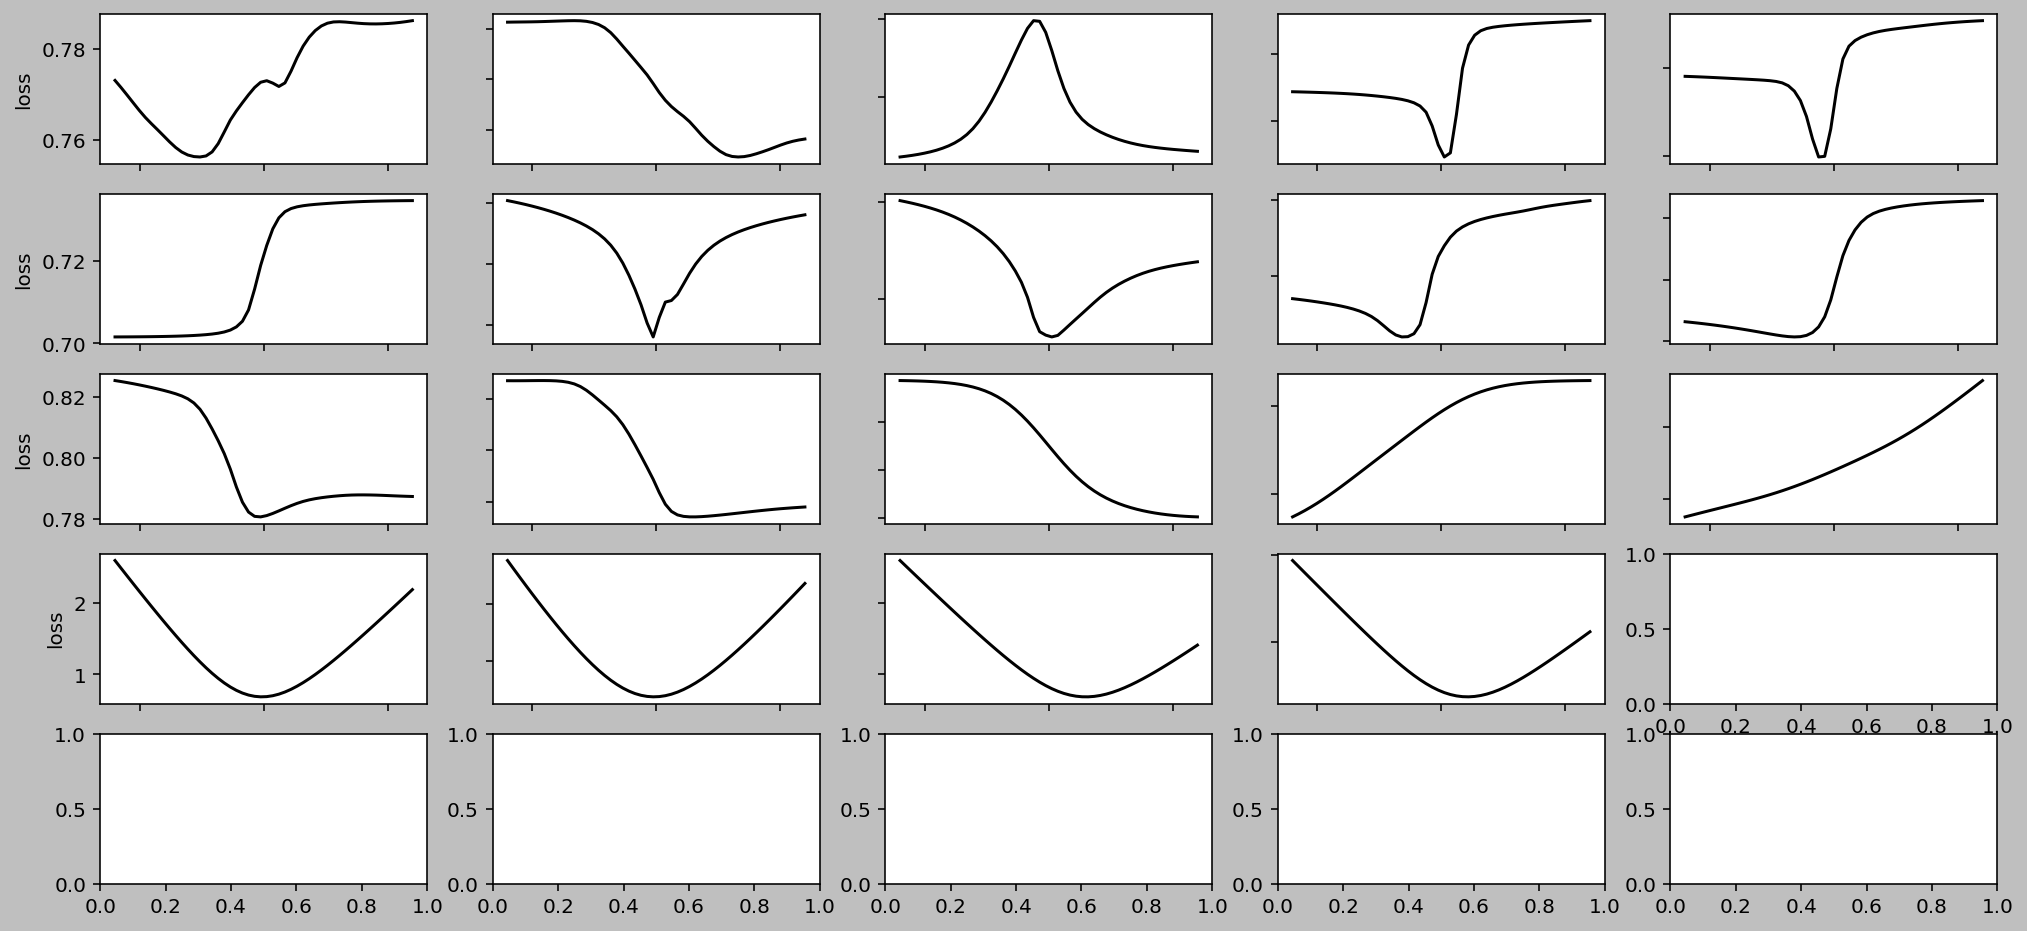

In [7]:
plot_all_weights_2d(m1)

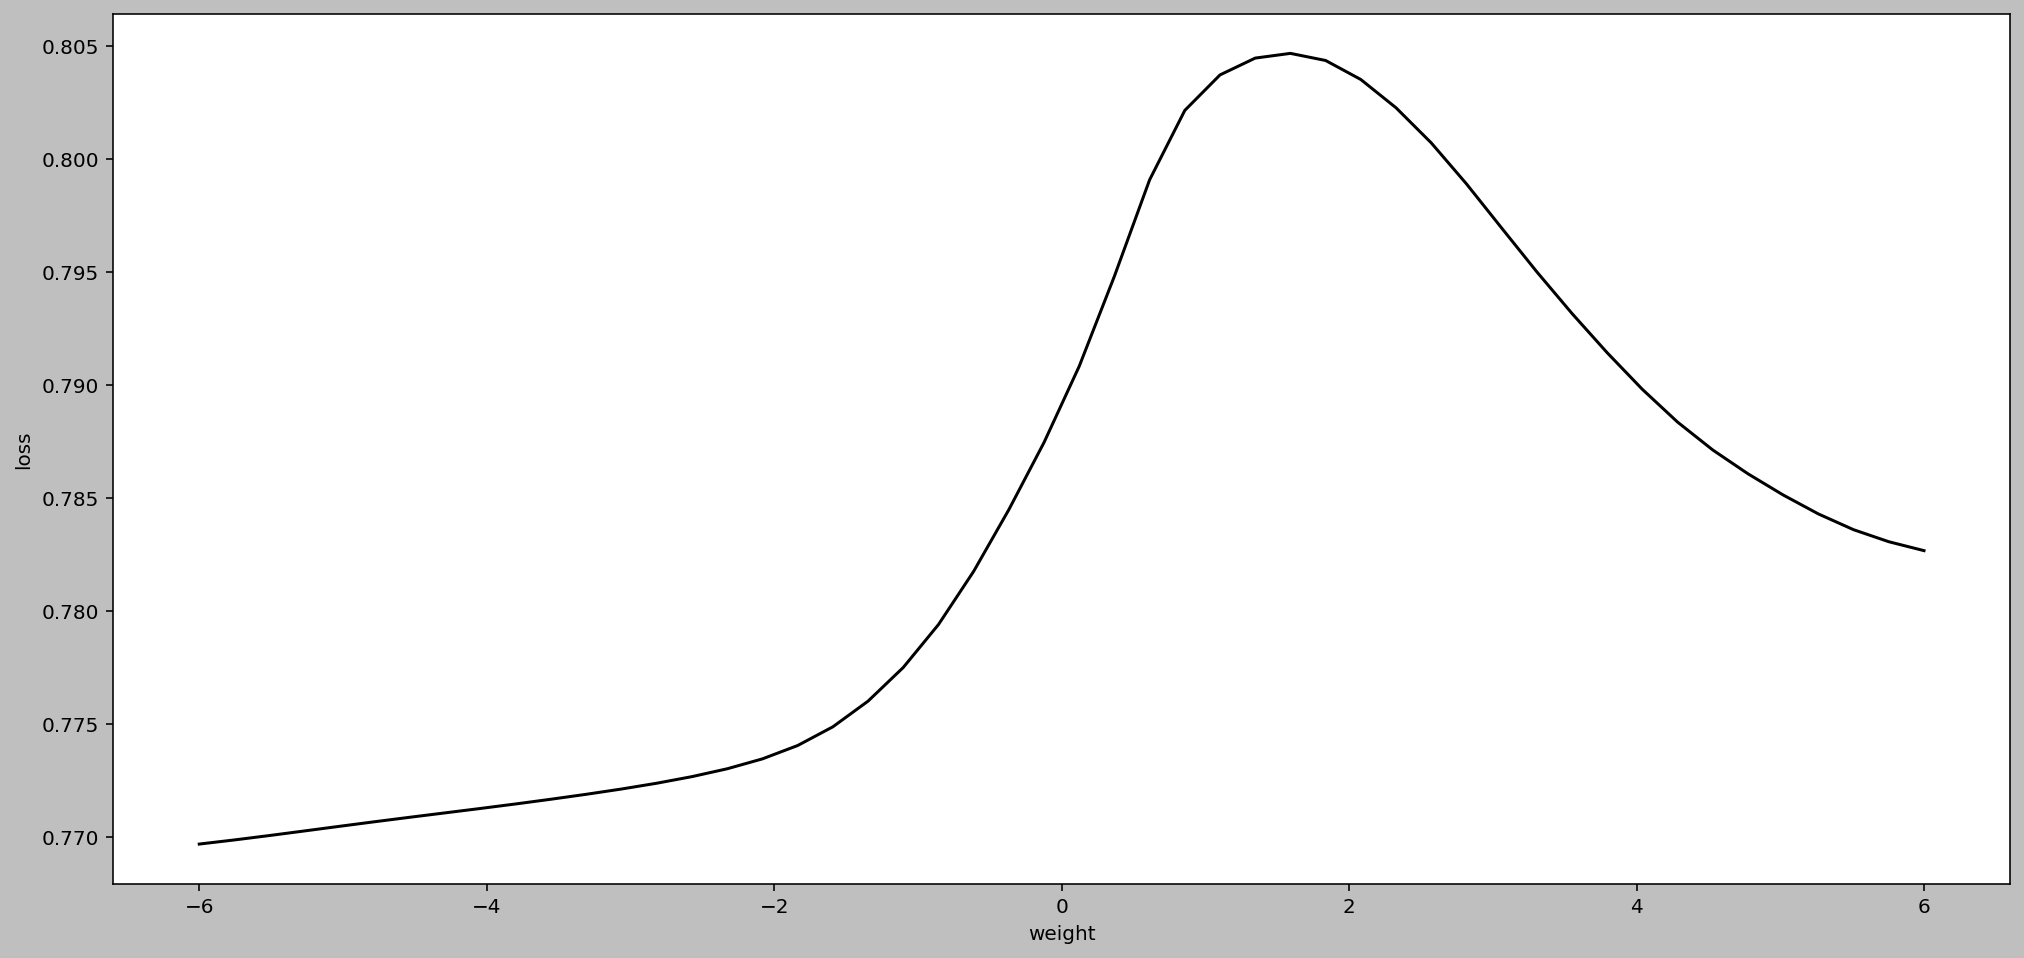

In [8]:
fig_single = plt.figure()
ax_single = fig_single.add_subplot()
plot_weight_2d(m1, ax_single, added)

100%|██████████| 50/50 [00:02<00:00, 19.13it/s]


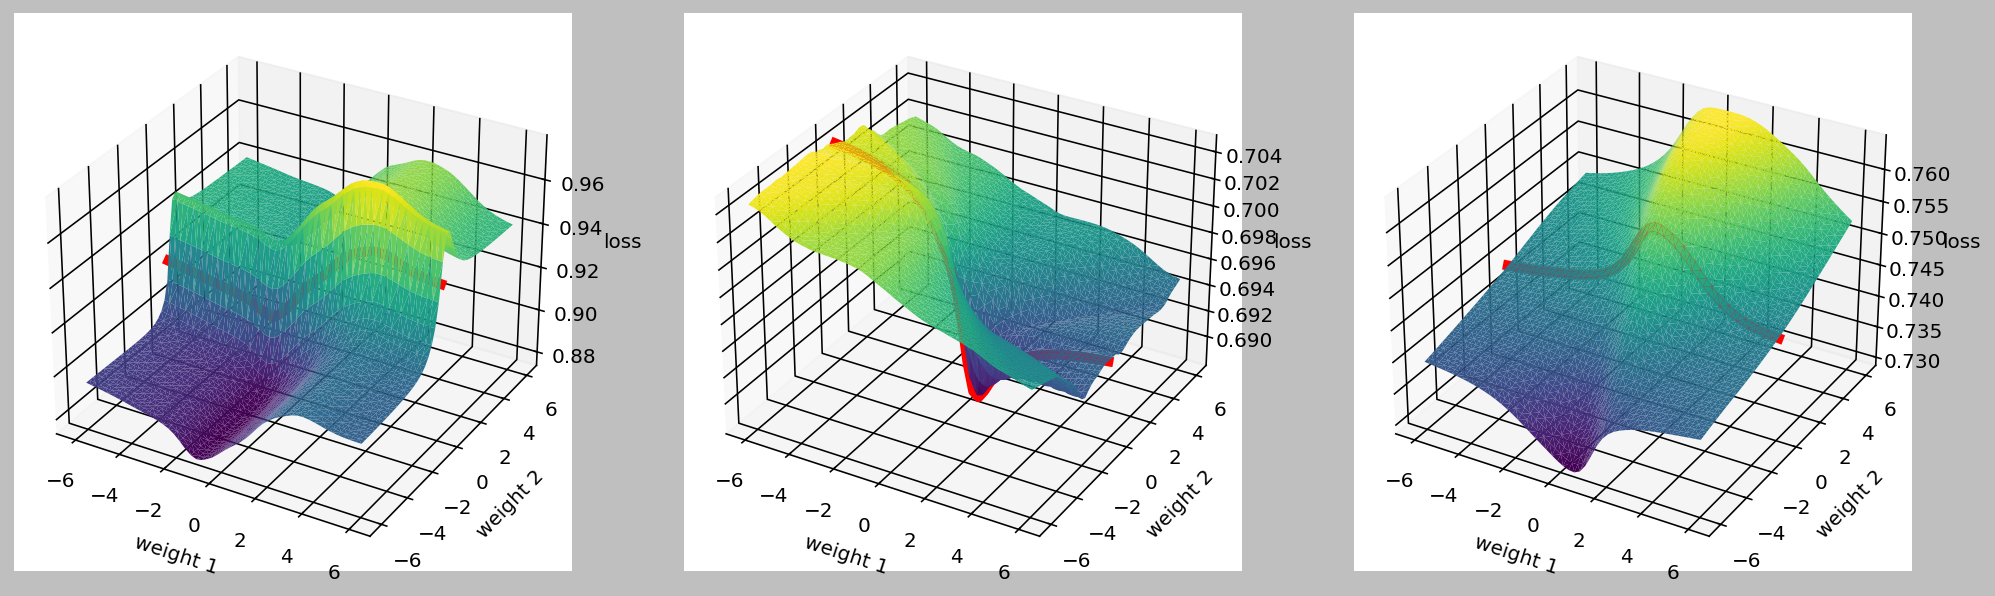

In [9]:
fig, axs = plt.subplots(ncols=len(checkers), subplot_kw={'projection': '3d'})

for i in range(len(checkers)):
    plot_weights_3d(m1, axs[i], added, checkers[i])

In [10]:
# mem = []
# precision = 20
#
# for n in range(0, 17):
#     mem.append(0)
#
#     for i in range(precision):
#         m = tf.keras.models.Sequential()
#         m.add(tf.keras.layers.Dense(n, input_shape=(4,), activation="sigmoid"))
#         m.add(tf.keras.layers.Dense(1, activation="sigmoid"))
#
#         m.compile(
#             optimizer=tf.keras.optimizers.SGD(learning_rate=0.04),
#             loss="binary_crossentropy",
#             metrics=["accuracy"]
#         )
#
#         m.fit(x_presim, y_presim, epochs=2, verbose=0)
#         v = m.evaluate(x_sim, y_sim)[1]
#         mem[n] = mem[n] if mem[n] > v else v
#
#     # mem[n] /= precision
#
# mem